# Project: Facial Age Verification (Computer Vision)

## Initialization

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
labels.isnull().sum()

file_name    0
real_age     0
dtype: int64

In [7]:
labels.duplicated().sum()

0

In [8]:
labels['file_name'].duplicated().sum()

0

In [9]:
# Data generator
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1/255
)

train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345,
    subset='training'
)

features_train, target_train = next(train_gen_flow)

print(features_train[0])

Found 5694 validated image filenames.
[[[0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  ...
  [0.1764706  0.15686275 0.07843138]
  [0.20784315 0.18823531 0.10980393]
  [0.2392157  0.21960786 0.14117648]]

 [[0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  ...
  [0.21568629 0.19215688 0.12941177]
  [0.21568629 0.19215688 0.12941177]
  [0.21176472 0.18823531 0.1254902 ]]

 [[0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  [0.8470589  0.85098046 0.8313726 ]
  ...
  [0.21176472 0.1764706  0.14117648]
  [0.20000002 0.16470589 0.12941177]
  [0.18823531 0.15294118 0.11764707]]

 ...

 [[0.46274513 0.45882356 0.4431373 ]
  [0.4666667  0.46274513 0.44705886]
  [0.47058827 0.4666667  0.45098042]
  ...
  [0.627451   0.5882353  0.58431375]
  [0.5568628  0.5019608  0.4901961 ]
  [0.5294118  0.46274513 0.43137258]]

 [[0.46274513 0.45882356 0.4431373 ]

## EDA

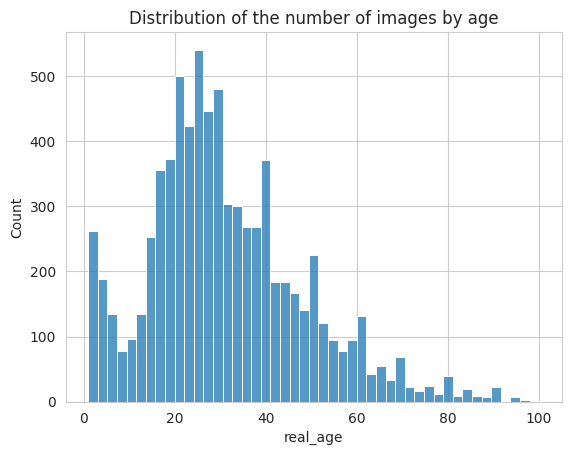

In [10]:
sns.set_style('whitegrid')
sns.histplot(labels['real_age'])
plt.title('Distribution of the number of images by age')
plt.show()

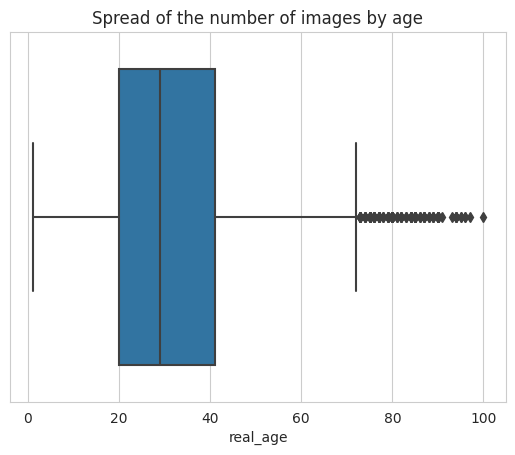

In [11]:
sns.boxplot(labels['real_age'])
plt.title('Spread of the number of images by age')
plt.show()

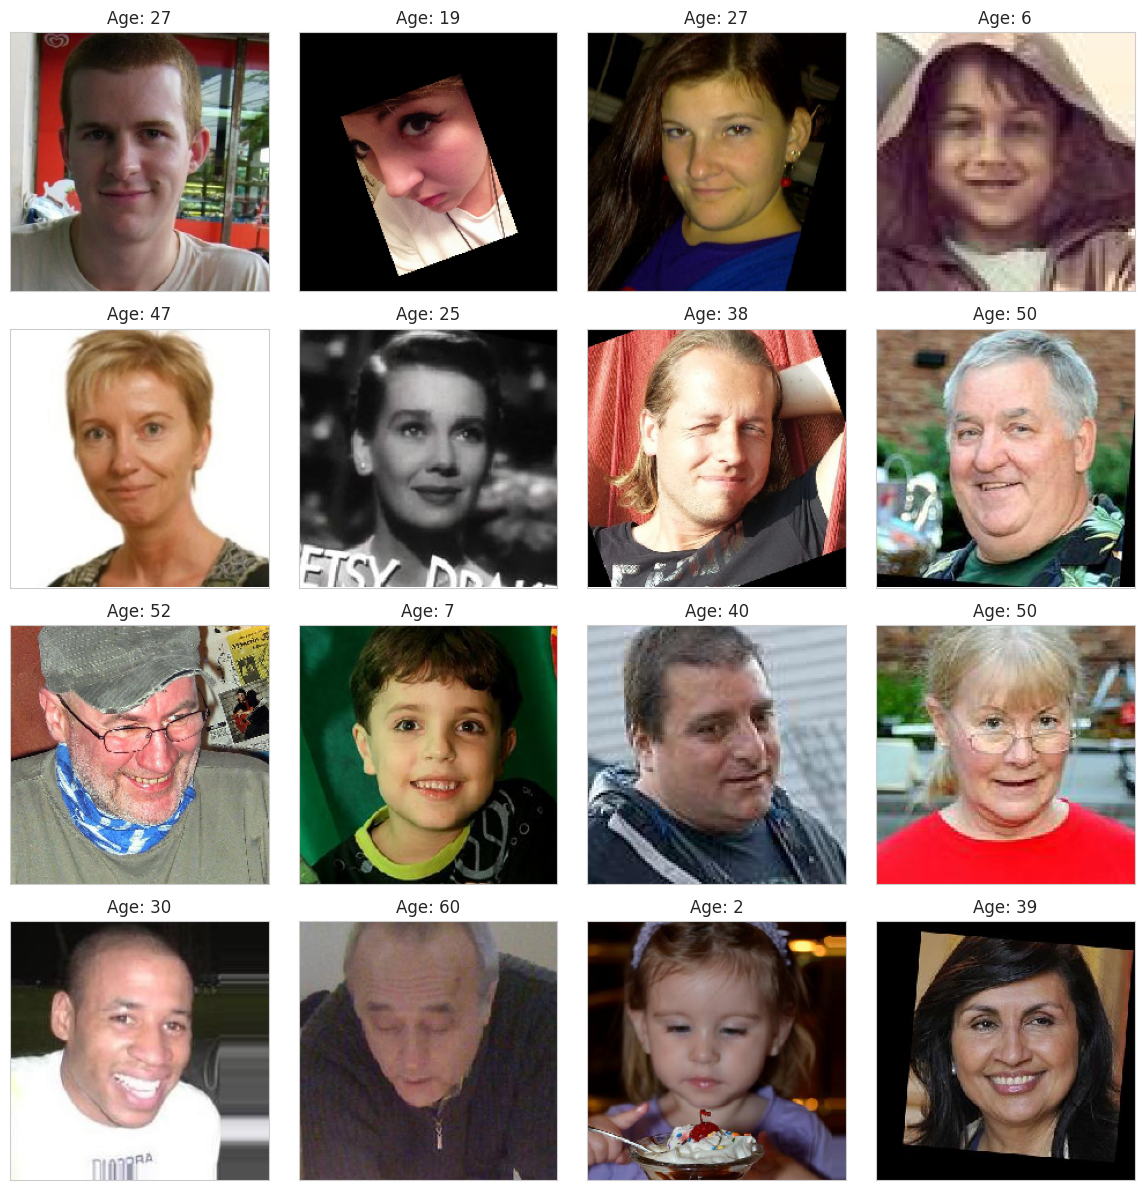

In [12]:
fig = plt.figure(figsize=(12, 12))

for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features_train[i])
    plt.title(f'Age: {target_train[i]}')
    # remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

A few observations from the EDA: based on the histogram, the distribution of images is positively skewed towards younger ages, with the median age in the early 30s. At left of the distribution is a large spike in images of 1 year olds.

Based on the boxplot, between the 25th to 75th percentile range, there is more of an abundance of images in the 20-40 age ranges. Outside of the overall range, any outliers fall beyond the early 70s (up until the max age of 100).

Some of the photos sampled show prior transformations. This means that augmentation was used on the dataset to prevent a deficit of samples for training and to increase its diversity, as to avoid overfitting and to help with improving performance for model training.

## Modeling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [13]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [14]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """

    df = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255
    )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training'
    )

    return train_gen_flow

In [15]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    df = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255
    )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation'
    )

    return test_gen_flow

In [16]:
def create_model(input_shape):
    
    """
    It defines model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [18]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

As a result of the training over 20 epochs, some improvements were gained with loss and MAE, which each decreased from their initial values over the course of the training. The ending validation MAE came out be 7.6512 (compared to 8.4921 at the start), while the ending validation loss came out to be 93.4115 (compared to 124.3362 at the start).

The results of the validation loss and MAE were not as consistent as the improvements seen with the training loss and MAE. Values were constantly jumping up before going back down at a few epochs (the most extreme example of this occurring around epoch 12). This suggests overfitting.

In the future, the training of the model might benefit from:

* Including optimizations for the model such as hyperparameter tuning
* Testing different neural network architectures
* Playing with the amount of convolutional layers (since the layers were minimal here)
* Trying additional image augmentations